In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from bs4 import BeautifulSoup

In [2]:
with open('./residents-subzone-2017.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [3]:
placemarks = [placemark for placemark in soup.find_all('Placemark')]

In [4]:
print(len(placemarks))

323


In [5]:
# reading one datapoint
sample = [
placemarks[0].get('id'),
placemarks[0].snippet,
# placemarks[0].description,
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"HDB"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"ONE_TO_TWO_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"THREE_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FOUR_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FIVE_RM_EXEC_FLATS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"CONDOS_OTHER_APTS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"LANDED_PROPERTIES"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"OTHERS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"INC_CRC"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FMEL_UPD_D"}),
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")],
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
]
sample

['kml_1',
 <snippet> </snippet>,
 <SimpleData name="SUBZONE_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="PLN_AREA_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="TOTAL">0</SimpleData>,
 <SimpleData name="HDB">0</SimpleData>,
 <SimpleData name="ONE_TO_TWO_RM">0</SimpleData>,
 <SimpleData name="THREE_RM">0</SimpleData>,
 <SimpleData name="FOUR_RM">0</SimpleData>,
 <SimpleData name="FIVE_RM_EXEC_FLATS">0</SimpleData>,
 <SimpleData name="CONDOS_OTHER_APTS">0</SimpleData>,
 <SimpleData name="LANDED_PROPERTIES">0</SimpleData>,
 <SimpleData name="OTHERS">0</SimpleData>,
 <SimpleData name="INC_CRC">A414A47E5AA4EDB5</SimpleData>,
 <SimpleData name="FMEL_UPD_D">20170927160941</SimpleData>]

In [6]:
placemark_data = []

for placemark in placemarks:
    placemark_data.append([
        placemark.get('id'),
        int(placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}).text),
        placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}).text,
        placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}).text,
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
        [[float(num) for num in pt.split(",")] 
         for pt in placemark.Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")]
    ])

In [7]:
df = pd.DataFrame(placemark_data, columns=["id", "TOTAL", "SUBZONE_N", "PLN_AREA_N", "boundary"])

In [8]:
sum(df["TOTAL"])

3966030

#### Calculate the centre of district

In [9]:
def centre_boundary(boundary):
    x_mean = sum([b[0] for b in boundary])/len(boundary)
    y_mean = sum([b[1] for b in boundary])/len(boundary)
    return x_mean, y_mean

In [10]:
df["x_centre"] = np.nan
df["y_centre"] = np.nan

In [11]:
for index, row in df.iterrows():
    x_mean, y_mean = centre_boundary(row["boundary"])
    df.at[index, "x_centre"] = x_mean
    df.at[index, "y_centre"] = y_mean

In [12]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre
169,kml_170,0,BRICKWORKS,BUKIT BATOK,"[[103.748411978891, 1.35271498210639, 0.0], [1...",103.743069,1.355037
16,kml_17,3330,PASIR PANJANG 2,QUEENSTOWN,"[[103.787926463495, 1.28168396692838, 0.0], [1...",103.795123,1.278643
250,kml_251,14030,SELETAR HILLS,SERANGOON,"[[103.858705911055, 1.37659703567972, 0.0], [1...",103.866631,1.384082
174,kml_175,83810,BEDOK NORTH,BEDOK,"[[103.943699468251, 1.33537408216272, 0.0], [1...",103.935561,1.330412
182,kml_183,32470,BALESTIER,NOVENA,"[[103.862331254613, 1.32956475291205, 0.0], [1...",103.851996,1.325809


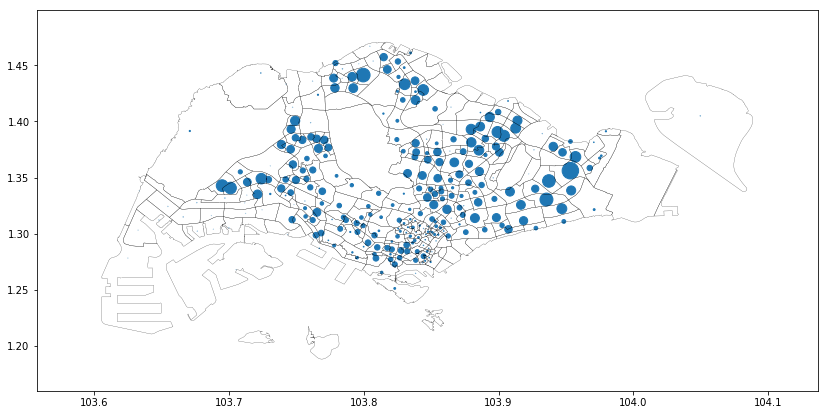

In [13]:
fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for b in df["boundary"]:
    n = len(b)
    for e,_ in enumerate(b):
        lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.show()

In [ ]:
df.loc[25]

In [ ]:
[[float(num) for num in pt.split(",")] 
 for pt in placemarks[26].Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")]
]

In [ ]:
[polygon for polygon in placemarks[25].MultiGeometry.Polygon]

In [ ]:
placemarks

In [ ]:
"aaa ".strip(" ")